In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM2D import TMCRBM2D
import gzip
import pickle
import functions
import h5py


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
data = torch.tensor(np.genfromtxt('../dataset/1kg_xtrain.d'), device = device, dtype = dtype)



In [3]:
data.shape

torch.Size([805, 4500])

In [4]:
data

tensor([[1., 0., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 1., 1., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.]], device='cuda:0')

In [5]:
fname = "../model/TMC2D/GENE/AllParametersGeneticData_TMC2DRBM_NGibbs50_Nmean20_Nh100_Nv805_Nmb500_Nepoch1000_lr_0.01_N20000_Npoint2500_Nchain10.h5"
f = h5py.File(fname, "r")
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)
alltimes = np.array(alltimes)

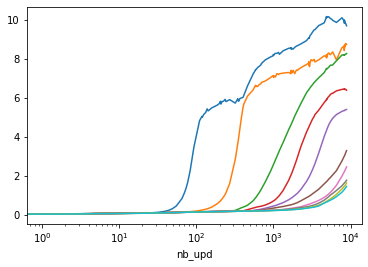

In [6]:
nvalsing = 10
S = torch.zeros(nvalsing, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    #plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:nvalsing]
#plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)
plt.plot(alltimes,S.T.cpu())
plt.semilogx()
plt.xlabel("nb_upd");

In [7]:
t = alltimes[-1]
#t=101
lr = 0.01
NGibbs = 70
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['W1']).shape[0]
Nv = data.shape[0]
ep_max = 50
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 50 # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 10000
border_length = 0.1

myRBM = TMCRBM2D(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )
myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM.W)
if torch.mean(V[:,0])<0:
    V = -V

In [8]:
proj_data =torch.mm(data.T, V).cpu()/myRBM.Nv**.5
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))

si, mi, _, _ = myRBM.Sampling(vinit, it_mcmc=100)
proj_gen = torch.mm(si.T, V).cpu().numpy()/myRBM.Nv**.5

In [9]:
square, p_m, w_hat_tmp = functions.ComputeProbabilityTMC2D(myRBM, data.T, nb_chain, it_mcmc, it_mean, N, nb_point_dim, border_length, device)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


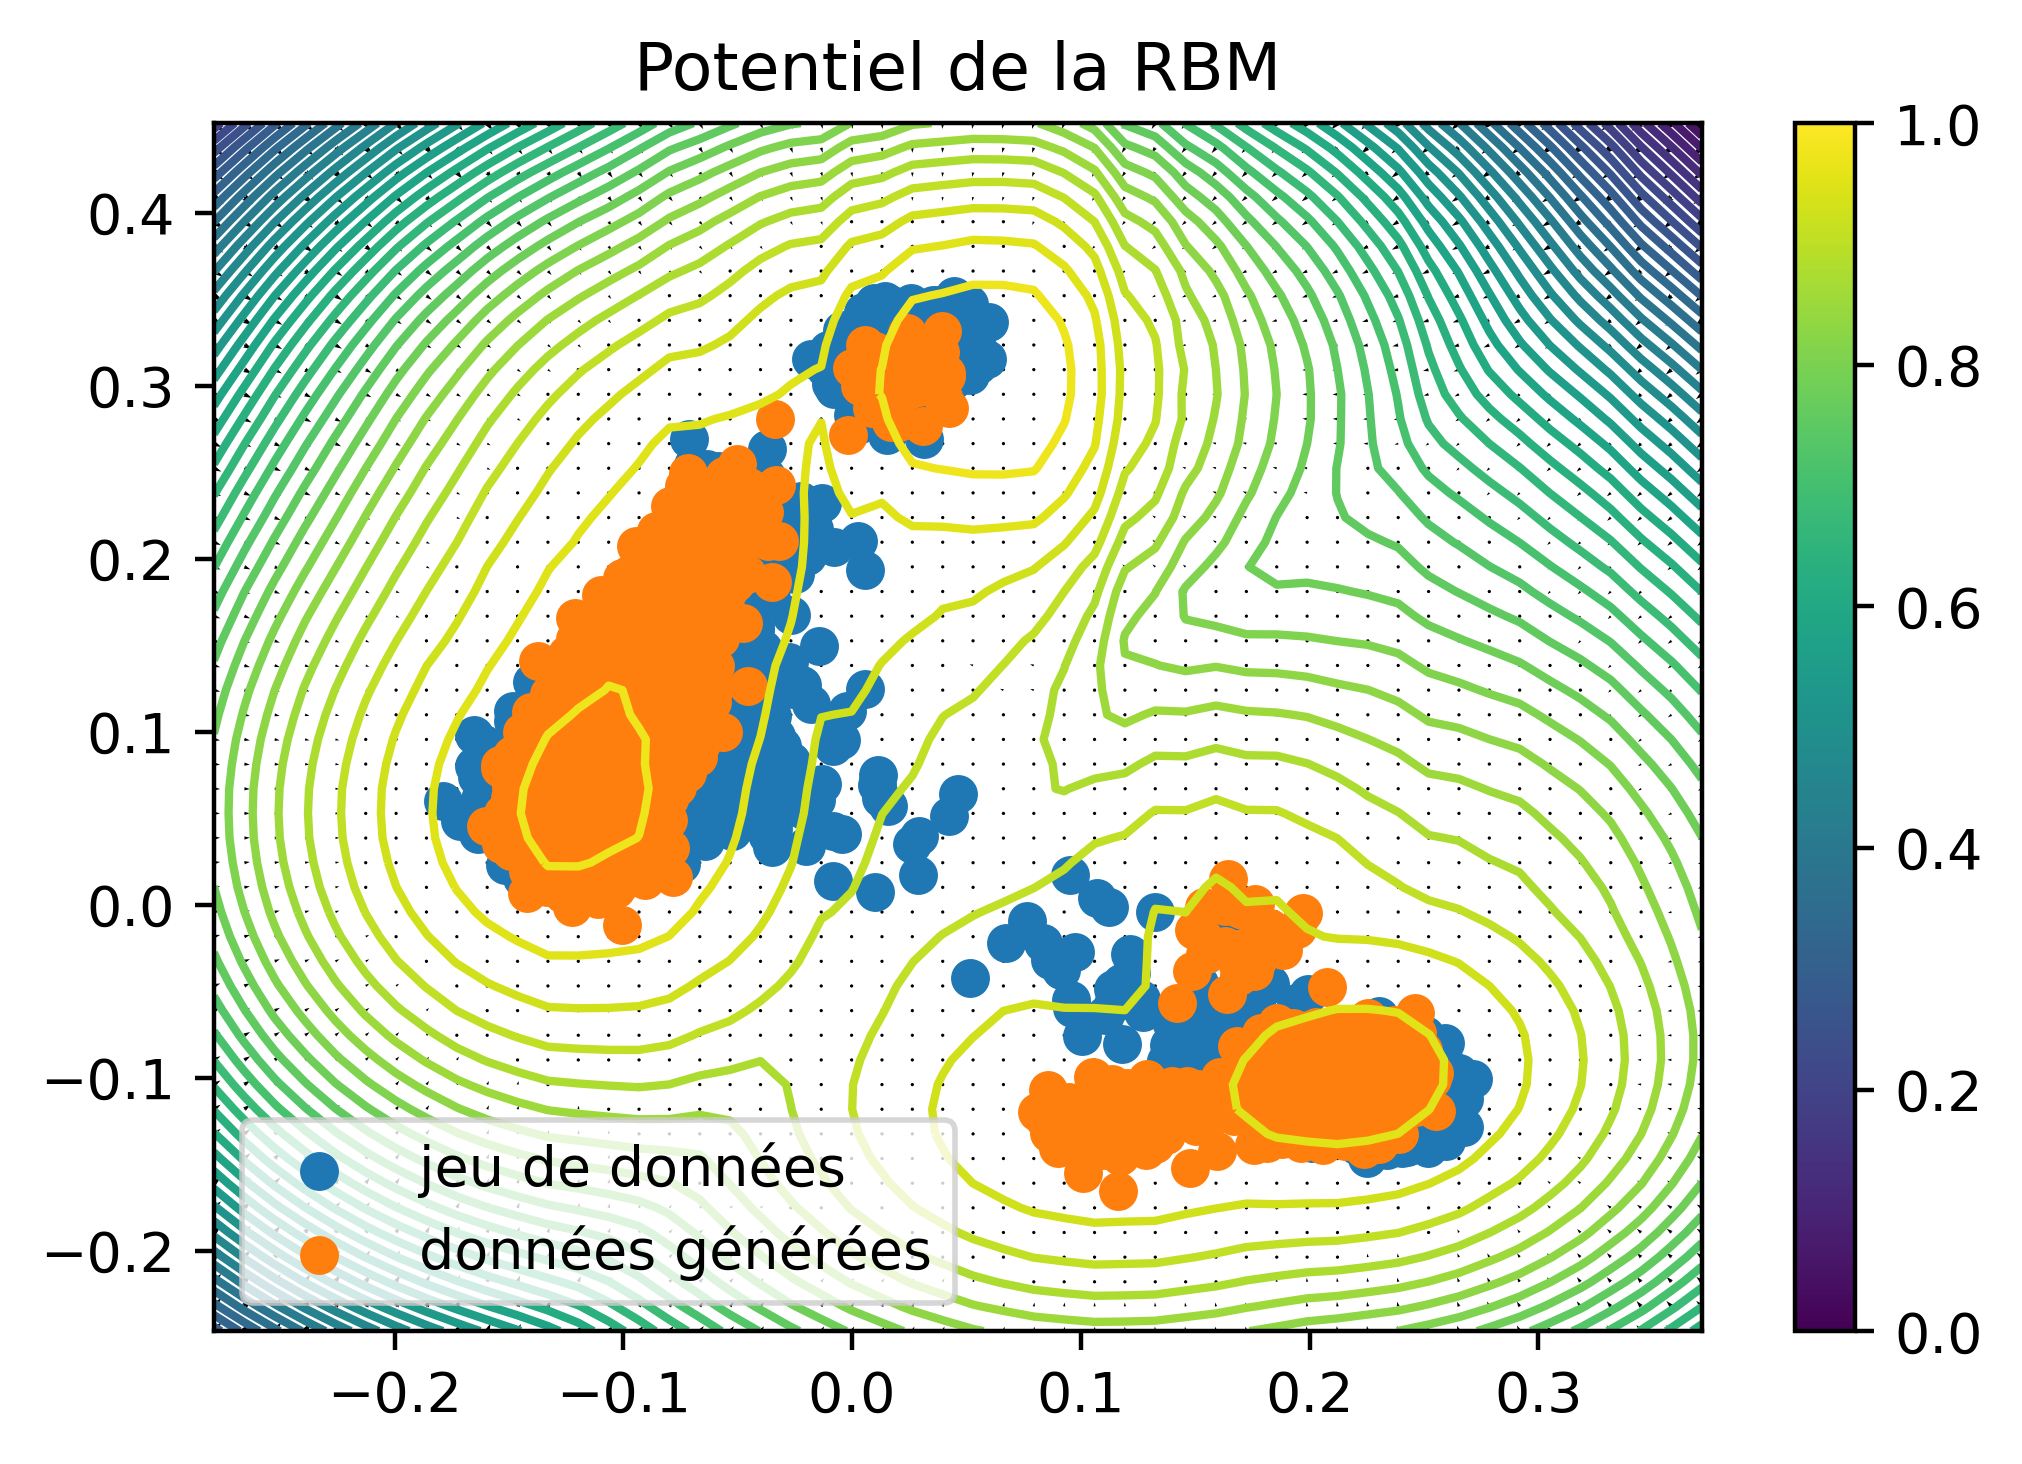

In [10]:
plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 50)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Potentiel de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/potentielGENE")

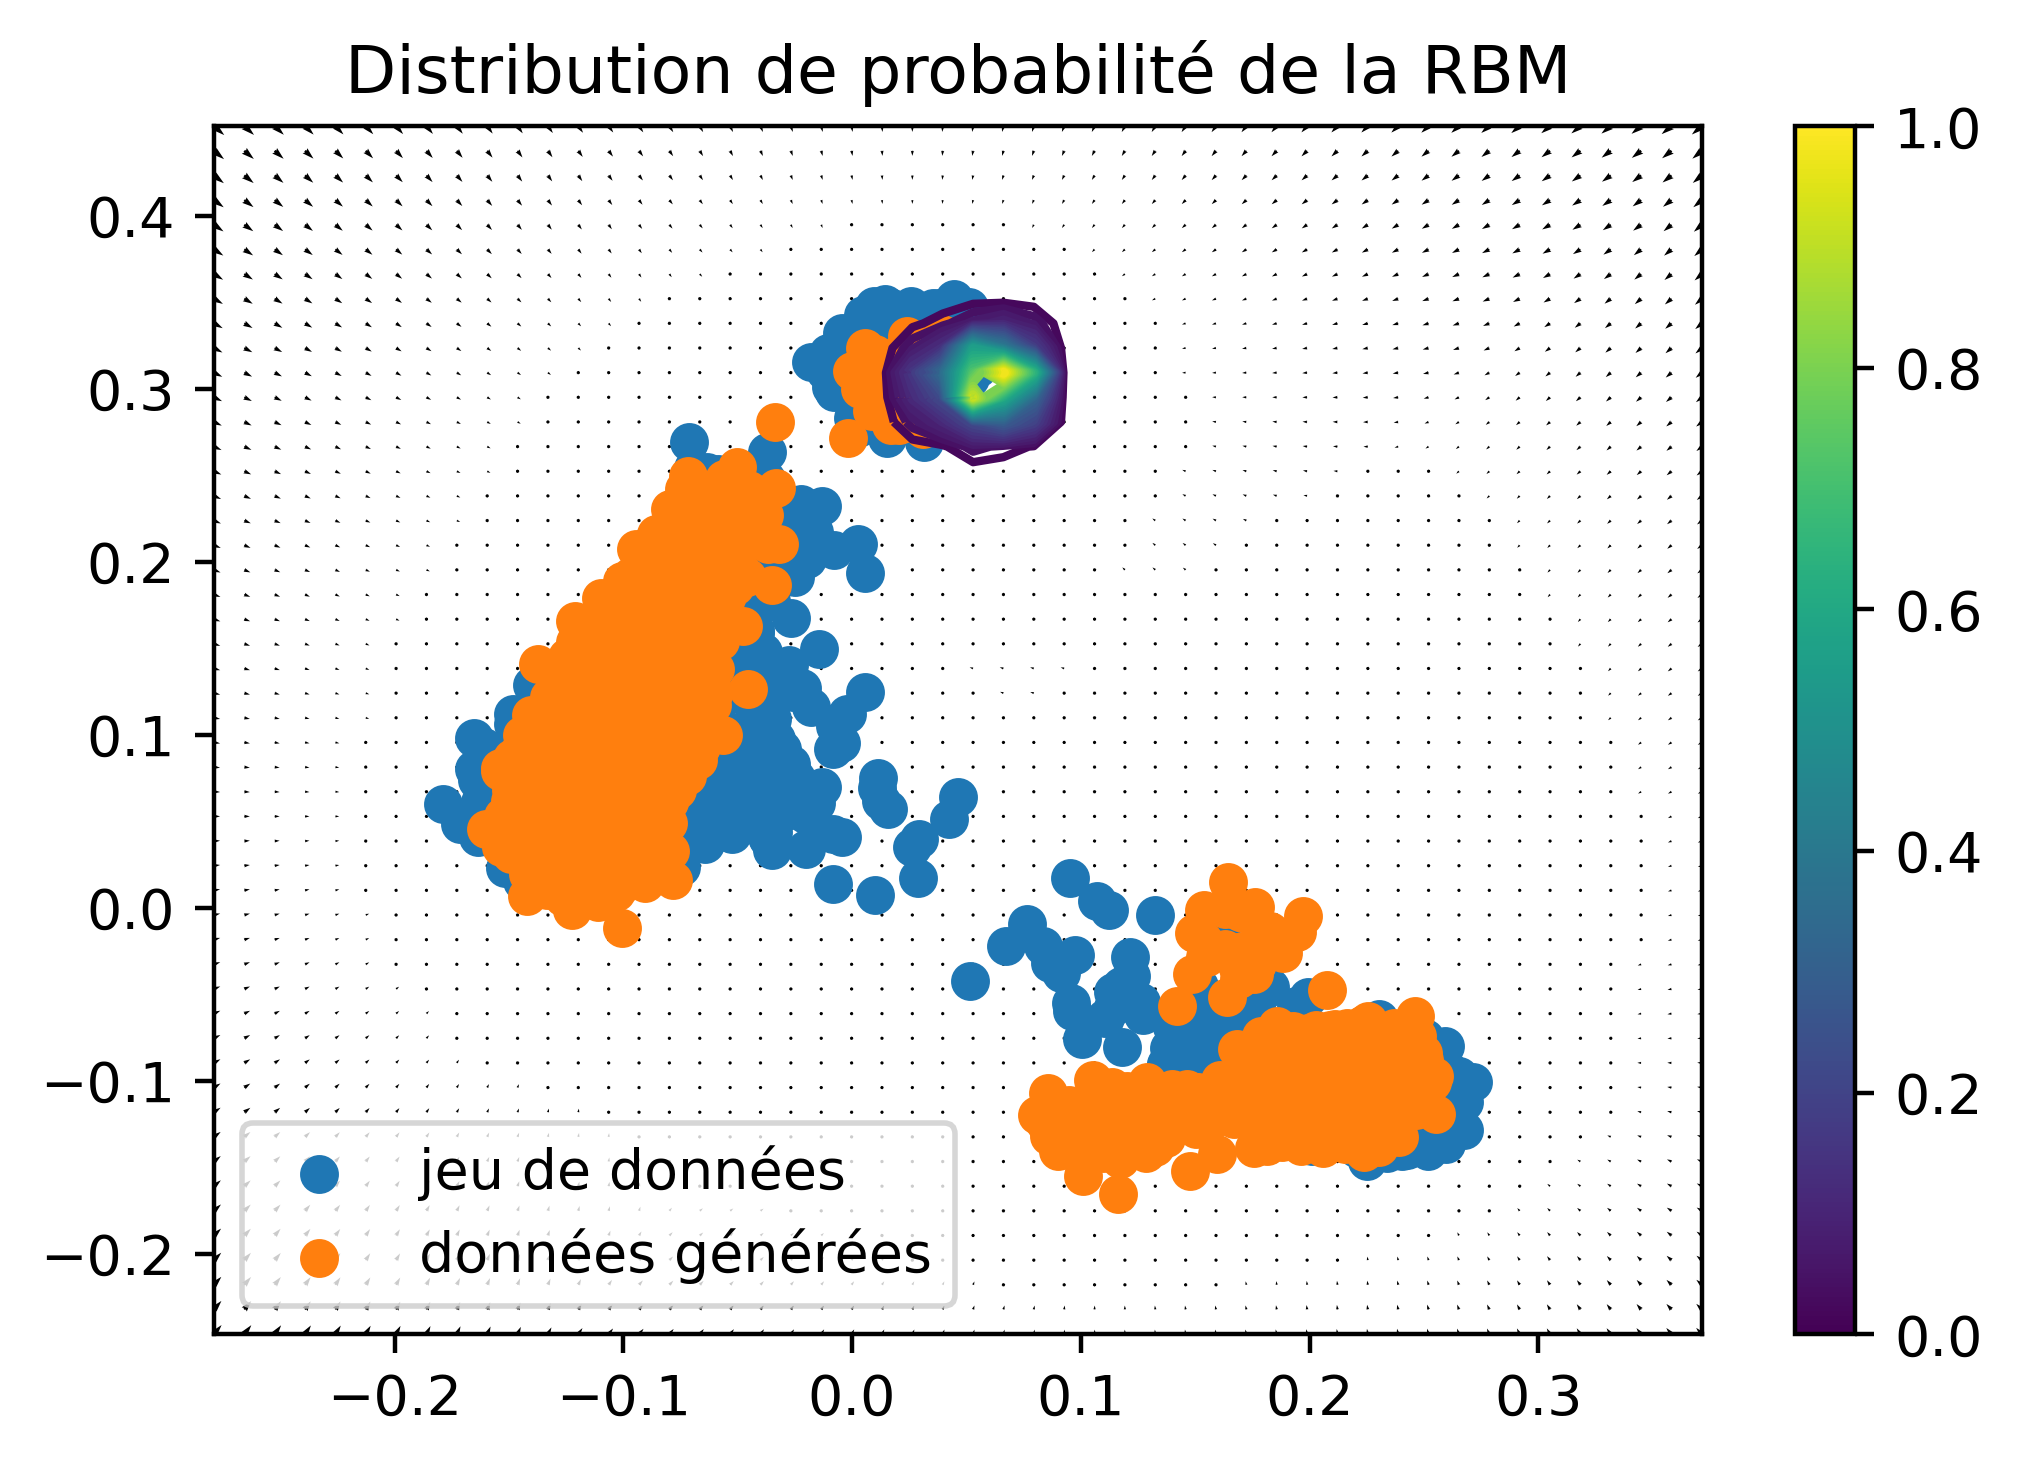

In [11]:
plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], (p_m), 50)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Distribution de probabilité de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/probaGENE")

In [12]:
data.shape

torch.Size([805, 4500])

In [13]:
alltimes

array([   0,    1,    2,    3,    4,    5,    6,    8,    9,   10,   12,
         14,   15,   16,   18,   22,   24,   25,   26,   28,   32,   38,
         41,   42,   43,   45,   48,   49,   55,   65,   69,   70,   71,
         73,   77,   82,   83,   93,  110,  118,  119,  120,  122,  126,
        132,  138,  142,  159,  187,  201,  202,  203,  205,  209,  215,
        225,  236,  242,  270,  319,  342,  343,  344,  346,  350,  356,
        366,  383,  402,  411,  460,  543,  582,  583,  584,  586,  590,
        596,  606,  623,  651,  684,  700,  783,  924,  990,  991,  992,
        994,  998, 1004, 1014, 1031, 1059, 1108, 1164, 1191, 1332, 1572,
       1683, 1684, 1685, 1687, 1691, 1697, 1707, 1724, 1752, 1801, 1884,
       1980, 2025, 2265, 2673, 2862, 2863, 2864, 2866, 2870, 2876, 2886,
       2903, 2931, 2980, 3063, 3204, 3366, 3444, 3852, 4545, 4866, 4867,
       4868, 4870, 4874, 4880, 4890, 4907, 4935, 4984, 5067, 5208, 5448,
       5724, 5856, 6549, 7728, 8272, 8273, 8274, 82

In [14]:
fname = "../model/AllParametersLongRUNExMC_GENE_FixTrainTest_Nh100_lr0.01_l20.0_NGibbs10000.h5"
f = h5py.File(fname, "r")
alltimes_2 = []
for t in f['alltime'][:]:
    if 'paramW'+str(t) in f:
        alltimes_2.append(t)
alltimes_2 = np.array(alltimes_2)

In [15]:
t = alltimes_2[-1]
#t=101
lr = 0.01
NGibbs = 70
annSteps = 0
mb_s = 600
num_pcd = 600
Nh = torch.tensor(f['paramW0']).shape[0]
Nv = data.shape[0]
ep_max = 50
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 50 # Nb it_mcmc pour chaque chaine
it_mean = 40 # Nb it considérée pour la moyenne temporelle de chaque chaine
nDim = 2
nb_point_dim = torch.tensor([50,50]) # -> doit avoir autant de terme que la valeur de nDim
N = 10000
border_length = 0.1

myRBM_2 = TMCRBM2D(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )
myRBM_2.W = torch.tensor(f['paramW'+str(t)], device = myRBM.device)
myRBM_2.hbias = torch.tensor(f['paramHB'+str(t)], device = myRBM.device)
myRBM_2.vbias = torch.tensor(f['paramVB'+str(t)], device = myRBM.device)
_, _, V = torch.svd(myRBM_2.W)
if torch.mean(V[:,0])<0:
    V = -V

In [16]:
proj_data =torch.mm(data.T, V).cpu()/myRBM.Nv**.5
vinit = torch.bernoulli(torch.rand(
        (myRBM_2.Nv, 10000), device=myRBM.device, dtype=myRBM.dtype))

si, mi, _, _ = myRBM_2.Sampling(vinit, it_mcmc=100)
proj_gen = torch.mm(si.T, V).cpu().numpy()/myRBM_2.Nv**.5

In [ ]:
square, p_m, w_hat_tmp = functions.ComputeProbabilityTMC2D(myRBM_2, data.T, nb_chain, it_mcmc, it_mean, N, nb_point_dim, border_length, device)


0
1
2
3
4
5
6
7
8
9


In [ ]:
plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], np.log(p_m), 50)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
#plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Potentiel de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/potentielGENEbad")

In [ ]:
plt.figure(dpi=400)
plt.quiver(w_hat_tmp[0], w_hat_tmp[1], square[0].cpu(), square[1].cpu(), scale = 20)
plt.contour(w_hat_tmp[0],w_hat_tmp[1], (p_m), 50)
plt.scatter(proj_data[:,0], proj_data[:,1], label = "jeu de données")
plt.scatter(proj_gen[:,0], proj_gen[:,1], label = "données générées")
plt.legend()
plt.title("Distribution de probabilité de la RBM")
plt.colorbar()
plt.savefig("../../Stage/rapport/fig/probaGENEbad")